# ARCOS Pipeline in python

This notebook ilustrates a example workflow from images to ARCOS analysis and visualization in napari. It uses the python package stardist for segmenting nuclei, skimage for image processing and trackpy for tracking cells over time.
Subsequently ARCOS is used to analyse and detect collective events.

Example dataset is downloadable from: https://arcos.gitbook.io/home/example-use-cases/detecting-collective-signalling-events-in-epithelial-cells

### Imports

In [3]:
import os
import skimage
import numpy

from napari import Viewer
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from skimage.measure import regionprops, regionprops_table
from skimage.util import map_array

import pandas as pd
import trackpy
from arcos4py import ARCOS
import errno

TAB20 = [
    "#1f77b4",
    "#aec7e8",
    "#ff7f0e",
    "#ffbb78",
    "#2ca02c",
    "#98df8a",
    "#d62728",
    "#ff9896",
    "#9467bd",
    "#c5b0d5",
    "#8c564b",
    "#c49c94",
    "#e377c2",
    "#f7b6d2",
    "#7f7f7f",
    "#c7c7c7",
    "#bcbd22",
    "#dbdb8d",
    "#17becf",
    "#9edae5",
]

### Custom Functions

In [20]:
def create_folders(path: str, folder: list):
    for i in folder:
        folder_to_make = os.path.join(path, i)
        try:
            os.makedirs(folder_to_make)
            print(f'folder "{i}" created')
        except OSError as e:
            print(f'folder "{i}" alrady exists')
            if e.errno != errno.EEXIST:
                raise
def remap_segmentation(df: pd.DataFrame, segmentation: list, timepoint_column: str = 'timepoint', label_column: str = 'label', measure_column: str = 'ERK') -> list:
    tracked_numpy = df[[timepoint_column, label_column, measure_column]].sort_values(timepoint_column).to_numpy()
    grouped_numpy = numpy.split(tracked_numpy,numpy.unique(tracked_numpy[:,0], return_index = True)[1][1:])
    ratio_remapped = []
    for img, grp in zip(segmentation, grouped_numpy):
        img_copy = map_array(img, grp[:,1], grp[:, 2])
        ratio_remapped.append(img_copy)
    return ratio_remapped

### Define variables and create output folders

In [5]:
PATH = 'example_data' # where you data is located   
FOLDER = 'mdck_ekar' # subfolder of PATH where images are stored
OUT_DATA = 'data' # subfolder of PATH where csv is stored
OUT_LABELS = 'stardist' # subfolder of PATH where stardist segmentation is stored
FILENAME = 'C3-041_Ori.tif'
full_path = os.path.join(PATH, FOLDER)
orig_images_path = os.path.join(PATH, FOLDER)
out_path_csv = os.path.join(PATH, OUT_DATA)
create_folders(PATH, [OUT_DATA, OUT_LABELS]) 

folder "data" created
folder "stardist" created


### Load segmentation model and image

In [7]:
model = StarDist2D.from_pretrained('2D_versatile_fluo') # standard stardist model for 2d segmentation
image_data = skimage.io.imread(os.path.join(orig_images_path, FILENAME))

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


### Apply segmentation and extract data from images

In [8]:
out_path_stardist = os.path.join(PATH, OUT_LABELS,  'stardist.tif')
segmentation = []
df = []

for t, tp_data in enumerate(image_data):
    print(f'analysing timepoint {t}')
    labels, _ = model.predict_instances(normalize(tp_data))
    labels = skimage.segmentation.clear_border(labels)
    dic = regionprops_table(labels, tp_data, properties=['label', 'centroid', 'intensity_mean', 'area'])
    dic['timepoint'] = numpy.repeat(t, len(dic['label']))
    df.append(pd.DataFrame(dic))
    skimage.segmentation.clear_border(labels)
    segmentation.append(labels)

# optionally save segmentation
skimage.io.imsave(out_path_stardist, numpy.stack(segmentation))

analysing timepoint 0
1/1 [==============================] - 0s 301ms/step
analysing timepoint 1
1/1 [==============================] - 0s 46ms/step
analysing timepoint 2
1/1 [==============================] - 0s 48ms/step
analysing timepoint 3
1/1 [==============================] - 0s 50ms/step
analysing timepoint 4
1/1 [==============================] - 0s 52ms/step
analysing timepoint 5
1/1 [==============================] - 0s 49ms/step
analysing timepoint 6
1/1 [==============================] - 0s 47ms/step
analysing timepoint 7
1/1 [==============================] - 0s 49ms/step
analysing timepoint 8
1/1 [==============================] - 0s 49ms/step
analysing timepoint 9
1/1 [==============================] - 0s 46ms/step
analysing timepoint 10
1/1 [==============================] - 0s 46ms/step
analysing timepoint 11
1/1 [==============================] - 0s 46ms/step
analysing timepoint 12
1/1 [==============================] - 0s 46ms/step
analysing timepoint 13
1/1 [======

3341345064.py (16): example_data\stardist\stardist.tif is a low contrast image


### Track nuclei and export data as csv

In [9]:
df_full = pd.concat(df)
df_full = df_full.rename(columns={"centroid-1": "x", "centroid-0": "y", 'intensity_mean': 'ERK'})
df_full = df_full.sort_values(['timepoint'])
df_tracked = trackpy.link_df(df_full, search_range = 10, memory = 2, t_column = 'timepoint')
df_tracked = df_tracked.reset_index(drop=True).rename(columns={'particle': "track_id"})
df_tracked.to_csv(out_path_csv+'\\tracked_data_fret.csv')

Frame 199: 134 trajectories present.


### Detect Collective events with ARCOS

In [10]:
ts = ARCOS(df_tracked, ["x", "y"], 'timepoint','track_id', 'ERK')
ts.interpolate_measurements()
ts.bin_measurements(biasMet='none', binThr=0.28)
df_arcos = ts.trackCollev(eps=40, minClsz=5)

### Filter Collective events

In [11]:
from arcos4py.tools import filterCollev

filterer = filterCollev(df_arcos, 'timepoint', 'clTrackID', 'track_id')
ts_filtered = filterer.filter(25, 10)

### Plot Noodleplot

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Time Point', ylabel='Position'>)

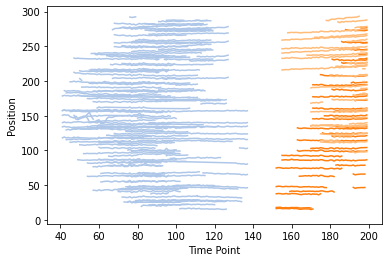

In [12]:
from arcos4py.plotting import NoodlePlot

NoodlePlot(ts_filtered, 'clTrackID', 'track_id', 'timepoint', 'x', 'y').plot('x')

In [13]:
np_data = df_tracked[['track_id', 'timepoint', 'y', 'x']].to_numpy()
colors = numpy.take(numpy.array(TAB20), ts_filtered['clTrackID'].unique(), mode="wrap")
df_w_colors = pd.merge(ts_filtered, pd.DataFrame(data={'colors': colors, 'clTrackID': ts_filtered['clTrackID'].unique()}))
points_data = df_w_colors[['timepoint', 'y', 'x']].to_numpy()
colors_data = df_w_colors['colors'].to_numpy('str')

### Remap measured Ratio to segmentation labels

In [21]:
ratio_remapped = numpy.stack(remap_segmentation(df_tracked, segmentation))

### Add various layers to napari

In [22]:
viewer = Viewer()
viewer.add_image(image_data, name='ERK Ratio image', colormap='inferno')
viewer.add_image(ratio_remapped, colormap='viridis')
viewer.add_labels(numpy.stack(segmentation), name='segmentation', visible=False)
viewer.add_tracks(np_data, name='cell tracks')
viewer.add_points(points_data, face_color=colors_data, name='collective events')

<Points layer 'collective events' at 0x2af88eb21a0>